In [2]:
import json
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [2]:
response = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=CAD&limit=2000')
json.loads(response.content)['Data']

[{'time': 1495929600,
  'high': 241.24,
  'low': 224.43,
  'open': 214.11,
  'volumefrom': 763668.32,
  'volumeto': 179478686.98,
  'close': 235.02,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1496016000,
  'high': 268.83,
  'low': 239.46,
  'open': 235.02,
  'volumefrom': 889605.13,
  'volumeto': 237597246.89,
  'close': 267.08,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1496102400,
  'high': 351.05,
  'low': 266.5,
  'open': 267.08,
  'volumefrom': 2148489.77,
  'volumeto': 716814224.72,
  'close': 333.64,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1496188800,
  'high': 353.57,
  'low': 309.92,
  'open': 333.64,
  'volumefrom': 1664236.28,
  'volumeto': 543996957.76,
  'close': 326.87,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1496275200,
  'high': 340.42,
  'low': 301.56,
  'open': 326.87,
  'volumefrom': 1104502.93,
  'volumeto': 344908629.27,
  'close': 312.27,
  'co

In [3]:
df = pd.DataFrame(json.loads(response.content)['Data'])
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1495929600,241.24,224.43,214.11,763668.32,1.794787e+08,235.02,multiply,BTC
1,1496016000,268.83,239.46,235.02,889605.13,2.375972e+08,267.08,multiply,BTC
2,1496102400,351.05,266.50,267.08,2148489.77,7.168142e+08,333.64,multiply,BTC
3,1496188800,353.57,309.92,333.64,1664236.28,5.439970e+08,326.87,multiply,BTC
4,1496275200,340.42,301.56,326.87,1104502.93,3.449086e+08,312.27,multiply,BTC


In [4]:
len(df)

2001

In [5]:
df = df.set_index('time')

In [6]:
df.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
1495929600,241.24,224.43,214.11,763668.32,1.794787e+08,235.02,multiply,BTC
1496016000,268.83,239.46,235.02,889605.13,2.375972e+08,267.08,multiply,BTC
1496102400,351.05,266.50,267.08,2148489.77,7.168142e+08,333.64,multiply,BTC
1496188800,353.57,309.92,333.64,1664236.28,5.439970e+08,326.87,multiply,BTC
1496275200,340.42,301.56,326.87,1104502.93,3.449086e+08,312.27,multiply,BTC


In [7]:
df = df[['high', 'low', 'open', 'volumefrom', 'volumeto', 'close']]
df.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
1495929600,241.24,224.43,214.11,763668.32,1.794787e+08,235.02
1496016000,268.83,239.46,235.02,889605.13,2.375972e+08,267.08
1496102400,351.05,266.50,267.08,2148489.77,7.168142e+08,333.64
1496188800,353.57,309.92,333.64,1664236.28,5.439970e+08,326.87
1496275200,340.42,301.56,326.87,1104502.93,3.449086e+08,312.27


In [8]:
def train_test_split(df):
    split_row = len(df) - int(0.1 * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(df)

In [9]:
len(train)

1801

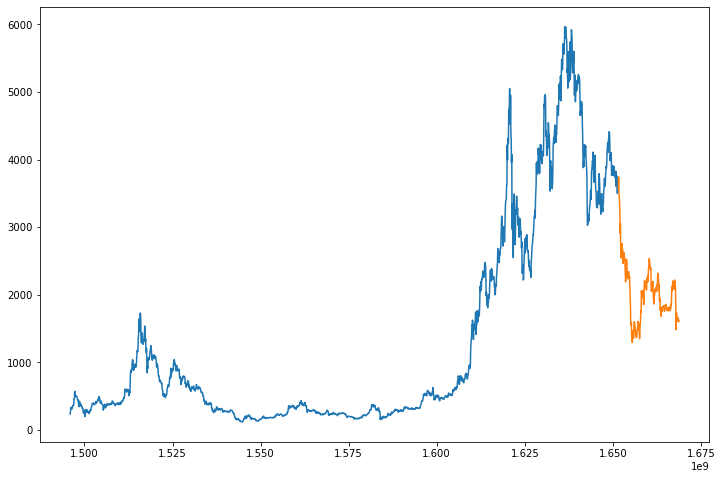

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(train['close'], label='train_data')
ax.plot(test['close'], label='test_data')

In [11]:
def norm_zero_base(df):
    return df / df.iloc[0] - 1

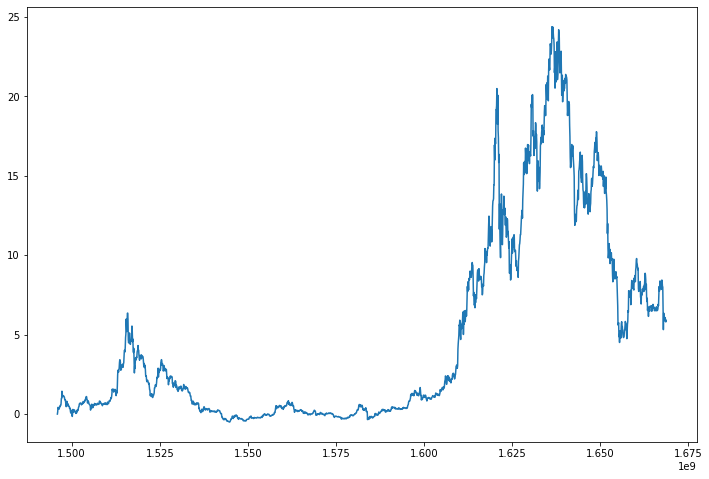

In [12]:
sample = norm_zero_base(df['close'])
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(sample, label='sample')

In [13]:
def norm_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

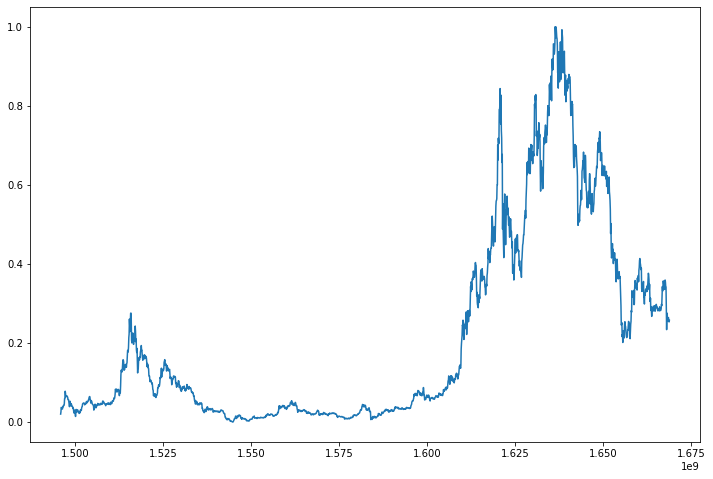

In [14]:
sample = norm_min_max(df['close'])
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(sample, label='sample')

In [15]:
def extract_windows_data(df):
    window_data = []
    for idx in range(len(df) - 10):
        tmp = df[idx: (idx + 10)].copy()
        tmp = norm_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [16]:
def prepare_data(df):
    train_data, test_data = train_test_split(df)
    X_train = extract_windows_data(train_data)
    X_test = extract_windows_data(test_data)
    y_train = train_data['close'][10:].values
    y_test = test_data['close'][10:].values
    
    y_train = y_train / train_data['close'][:-10].values - 1
    y_test = y_test / test_data['close'][:-10].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [17]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df)

In [18]:
X_train[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.11436743,  0.06696966,  0.09766008,  0.16491035,  0.32381873,
         0.13641392],
       [ 0.45518985,  0.18745266,  0.2473962 ,  1.81338078,  2.99386822,
         0.41962386],
       [ 0.46563588,  0.38092055,  0.55826444,  1.17926584,  2.03098361,
         0.3908178 ],
       [ 0.41112585,  0.34367063,  0.52664518,  0.44631236,  0.92172472,
         0.32869543],
       [ 0.37497927,  0.38002941,  0.45845593, -0.15155111,  0.12240174,
         0.32290869],
       [ 0.336387  ,  0.33899211,  0.45210406, -0.18811599,  0.06986885,
         0.31776019],
       [ 0.46406069,  0.37789066,  0.44645276, -0.5034191 , -0.27652981,
         0.45689729],
       [ 0.50758581,  0.52100878,  0.59917799, -0.41412191, -0.14893882,
         0.45264233],
       [ 0.54224009,  0.5232812 ,  0.5945075 , -0.02767763,  0.50054168,
         0.54327291]])

In [19]:
y_train

array([ 0.52663603,  0.36153961,  0.14692483, ..., -0.09000827,
       -0.03399006, -0.02355928])

In [20]:
len(X_test)

190

In [21]:
len(y_test)

190

In [22]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.add(Activation('relu'))

model.compile(loss='mse', optimizer='adam')

In [23]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, shuffle=True, verbose=1)

Epoch 1/200
56/56 [==============================] - 6s 7ms/step - loss: 0.0199
Epoch 2/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0151
Epoch 3/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 4/200
56/56 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 5/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 6/200
56/56 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 7/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 8/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 9/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 10/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 11/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 12/200
56/56 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 13/200
56/56 [=================

In [24]:
targets = test['close'][10:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

6/6 [==============================] - 1s 7ms/step


0.08760798966020397

In [25]:
preds

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01178318, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06577019, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02562353,
       0.03574862, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.14563346,
       0.09382176, 0.19218986, 0.02322882, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08866145, 0.11375748, 0.13835838, 0.11281207,
       0.03886984, 0.        , 0.        , 0.05279936, 0.03793675,
       0.08301414, 0.0975538 , 0.30947506, 0.36194038, 0.3693156 ,
       0.48183316, 0.3997475 , 0.27225283, 0.27481472, 0.06762

In [26]:
len(preds)

190

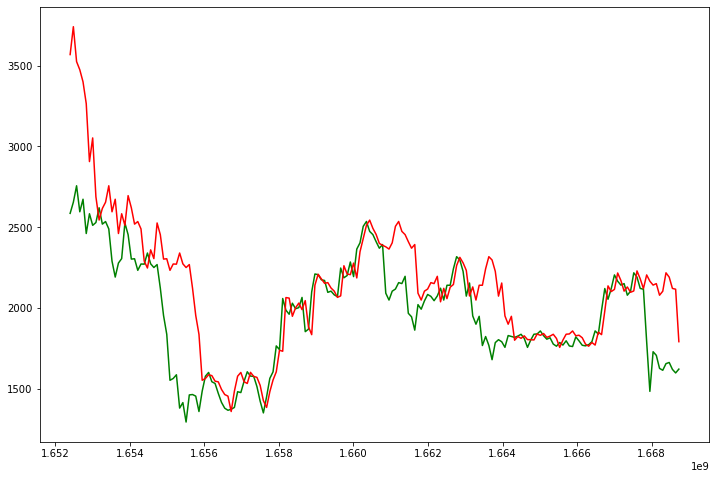

In [27]:
preds_plt = preds.copy()
preds_plt = test['close'].iloc[:190].values * (preds_plt + 1)
preds_plt = pd.Series(index=targets.index, data=preds_plt)
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(targets, label='target', color='green')
ax.plot(preds_plt, label='predics', color='red')